# CIFAR10 classification using Trax

[Trax](https://trax-ml.readthedocs.io/en/latest/) is an end-to-end library for deep learning that focuses on clear code and speed. It is actively used and maintained in the [Google Brain team](https://research.google.com/teams/brain/).

GitHub repo: https://github.com/google/trax

The basic units in Trax are *tensors*, using numpy interface.

In Trax numpy operations are accelerated using GPU or TPU. The gradients of functions on tensors are automatically computed. This is done in the `trax.fastmath` package which supports two backends:
- [JAX](https://github.com/google/jax)
- [TensorFlow numpy](https://www.tensorflow.org/guide/tf_numpy).

Other libraries on top of JAX:
- [Flax](https://flax.readthedocs.io/en/latest/) (also by Google)
- [Haiku](https://dm-haiku.readthedocs.io/en/latest/) (by Google [DeepMind](https://deepmind.com/))
- [Elegy](https://poets-ai.github.io/elegy/)

Installing JAX: https://github.com/google/jax#pip-installation

## Configuration

Imports

In [1]:
import trax
from trax import layers as tl
from trax import shapes
from trax.fastmath import numpy as jnp
from trax.supervised import training

import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Disable GPU usage by TensorFlow:

In [3]:
tf.config.set_visible_devices([], 'GPU')

In [4]:
print("Current trax backend:", trax.fastmath.backend_name())

Current trax backend: jax


In [5]:
print("Number of CPU or TPU devices:", trax.fastmath.device_count())

Number of CPU or TPU devices: 1


Configuration

In [6]:
NUM_CLASSES = 10

BATCH_SIZE = 32

NUM_STEPS = 20000
STEPS_PER_CHECKPOINT = 1000
EVAL_BATCHES = 300
WARMUP_STEPS = 500
MAX_LR = 1e-3
OUTPUT_DIR = 'output'

In [7]:
!rm -rf {OUTPUT_DIR}

## Dataset

In [8]:
def augment_image(img):
    img = tf.image.resize_with_crop_or_pad(img, 40, 40)
    img = tf.image.random_crop(img, [32, 32, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img

In [9]:
def Augment(generator):
    for imgs, tgts in generator:
        for i in range(len(imgs)):
            imgs[i] = augment_image(imgs[i])
        yield (imgs, tgts)

In [10]:
def ToFloat(generator):
    for img, tgt in generator:
        img = img.astype(np.float32) / 255.0
        yield (img, tgt)

In [11]:
train_stream = trax.data.Serial(
    trax.data.TFDS('cifar10', data_dir='data', keys=('image', 'label'), train=True),
    trax.data.Shuffle(),
    trax.data.Batch(BATCH_SIZE),
    Augment,
    ToFloat,
    trax.data.AddLossWeights() # needed for tl.CrossEntropyLoss
)

In [12]:
eval_stream = trax.data.Serial(
    trax.data.TFDS('cifar10', data_dir='data', keys=('image', 'label'), train=False),
    trax.data.Batch(BATCH_SIZE),
    ToFloat,
    trax.data.AddLossWeights()
)

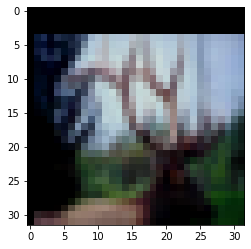

In [13]:
# Test generator:
batch = next(train_stream())
img = batch[0][0]
plt.imshow(img);

## Model

In [14]:
def ConvBlock(filters, kernel_size=3, strides=1, act=True, mode='train'):
    layers = [
        tl.Conv(filters, (kernel_size, kernel_size), strides=(strides, strides), padding='SAME',
                kernel_initializer=tl.initializers.KaimingNormalInitializer()),
        tl.BatchNorm(mode=mode)
    ]
    if act: layers.append(tl.Relu())
    return layers

In [15]:
def BasicResidual(res_filters, strides=1, mode='train'):
    return [
        ConvBlock(res_filters, strides=strides, mode=mode),
        ConvBlock(res_filters, act=False, mode=mode)
    ]

In [16]:
def Shortcut(prev_filters, res_filters, strides=1, mode='train'):
    layers = []
    if strides > 1:
        layers.append(tl.AvgPool((strides, strides), (strides, strides)))
    if prev_filters != res_filters:
        layers += ConvBlock(res_filters, kernel_size=1, act=False, mode=mode)
    if len(layers) == 0: layers = None
    return layers

In [17]:
def ZerosInitializer(shape, rng):
    return jnp.zeros(shape, jnp.float32)

In [18]:
def ResidualBlock(prev_filters, res_filters, strides=1, mode='train'):
    shortcut = Shortcut(prev_filters, res_filters, strides, mode=mode)
    residual = [
        BasicResidual(res_filters, strides, mode=mode),
        tl.Weights(ZerosInitializer, shape=(1,)),
        tl.Multiply()
    ]
    return [
        tl.Residual(residual, shortcut=shortcut),
        tl.Relu()
    ]

In [19]:
def ResidualBody(filters, repetitions, strides, mode='train'):
    layers = []
    res_filters = filters
    for rep, stride in zip(repetitions, strides):
        for _ in range(rep):
            layers.append(ResidualBlock(filters, res_filters, stride, mode=mode))
            filters = res_filters
            stride = 1
        res_filters *= 2
    return layers

In [20]:
def Stem(filter_list, stride=1, mode='train'):
    layers = []
    for filters in filter_list:
        layers.append(ConvBlock(filters, strides=stride, mode=mode))
        stride = 1
    return layers

In [21]:
def GlobalAvgPool():
    def pool(x):
        pool_size = tuple(x.shape[1:3]) # NHWC
        return trax.fastmath.avg_pool(x, pool_size=pool_size, strides=None, padding='VALID')
    
    return tl.Fn("GlobalAvgPool", pool)

In [22]:
def Head(classes, p_drop=0., mode='train'):
    layers = [
        GlobalAvgPool(),
        tl.Flatten()
    ]
    if p_drop > 0: layers.append(tl.Dropout(p_drop, mode=mode))
    layers += [
        tl.Dense(classes),
        tl.LogSoftmax()
    ]
    return layers

In [23]:
def ResNet(repetitions, classes, strides=None, p_drop=0., mode='train'):
    if not strides: strides = [2] * (len(repetitions) + 1)
    return tl.Serial(
        Stem([32, 32, 64], stride=strides[0], mode=mode),
        ResidualBody(64, repetitions, strides[1:], mode=mode),
        Head(classes, p_drop=p_drop, mode=mode)
    )

In [24]:
def MyModel(mode='train'):
    return ResNet([2, 2, 2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2], p_drop=0.3, mode=mode)

In [25]:
model = MyModel()

In [26]:
eval_model = MyModel(mode='eval')

In [27]:
model

Serial[
  Conv
  BatchNorm
  Relu
  Conv
  BatchNorm
  Relu
  Conv
  BatchNorm
  Relu
  Serial[
    Branch_out2[
      None
      Serial[
        Conv
        BatchNorm
        Relu
        Conv
        BatchNorm
        Weights_(1,)_in0
        Multiply_in2
      ]
    ]
    Add_in2
  ]
  Relu
  Serial[
    Branch_out2[
      None
      Serial[
        Conv
        BatchNorm
        Relu
        Conv
        BatchNorm
        Weights_(1,)_in0
        Multiply_in2
      ]
    ]
    Add_in2
  ]
  Relu
  Serial[
    Branch_out2[
      [AvgPool(2,2), Conv, BatchNorm]
      Serial[
        Conv
        BatchNorm
        Relu
        Conv
        BatchNorm
        Weights_(1,)_in0
        Multiply_in2
      ]
    ]
    Add_in2
  ]
  Relu
  Serial[
    Branch_out2[
      None
      Serial[
        Conv
        BatchNorm
        Relu
        Conv
        BatchNorm
        Weights_(1,)_in0
        Multiply_in2
      ]
    ]
    Add_in2
  ]
  Relu
  Serial[
    Branch_out2[
      [AvgPool(2,2),

## Training

In [28]:
train_task = training.TrainTask(
    labeled_data=train_stream(),
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=trax.supervised.lr_schedules.warmup_and_rsqrt_decay(WARMUP_STEPS, MAX_LR),
    n_steps_per_checkpoint=STEPS_PER_CHECKPOINT
)

In [29]:
eval_task = training.EvalTask(
    labeled_data=eval_stream(),
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
    n_eval_batches=EVAL_BATCHES
)

In [30]:
training_loop = training.Loop(
    model,
    train_task,
    eval_model=eval_model,
    eval_tasks=eval_task,
    output_dir=OUTPUT_DIR
)

/home/aiserver/.virtualenvs/deeplearning/lib/python3.6/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [31]:
training_loop.run(NUM_STEPS)


Step      1: Total number of trainable weights: 11205746
Step      1: Ran 1 train steps in 16.24 secs
Step      1: train CrossEntropyLoss |  2.61132336
Step      1: eval  CrossEntropyLoss |  10.20209974
Step      1: eval          Accuracy |  0.10989583

Step   1000: Ran 999 train steps in 116.09 secs
Step   1000: train CrossEntropyLoss |  1.76638615
Step   1000: eval  CrossEntropyLoss |  3.25688744
Step   1000: eval          Accuracy |  0.18250000

Step   2000: Ran 1000 train steps in 106.21 secs
Step   2000: train CrossEntropyLoss |  1.18806684
Step   2000: eval  CrossEntropyLoss |  1.69844913
Step   2000: eval          Accuracy |  0.48614583

Step   3000: Ran 1000 train steps in 106.53 secs
Step   3000: train CrossEntropyLoss |  0.94432074
Step   3000: eval  CrossEntropyLoss |  1.09890646
Step   3000: eval          Accuracy |  0.64437500

Step   4000: Ran 1000 train steps in 105.61 secs
Step   4000: train CrossEntropyLoss |  0.80568272
Step   4000: eval  CrossEntropyLoss |  1.236077